In [1]:
from PreFRBLE.likelihood import *
from PreFRBLE.plot import *


to identify LoS with intervening galaxies, compare the likelihood of temporal broadening $\tau$ for scenarios with and without intervening galaxies

In [6]:
scenario_inter = {
    'IGM' : ['primordial'],
#    'Host' : ['Rodrigues18/smd'],
#    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
}

scenario_nointer = {
    'IGM' : ['primordial'],
#    'Host' : ['Rodrigues18/smd'],
#    'Inter' : ['Rodrigues18'],
#    'Local' : ['Piro18/wind'],
}



first, compare the distribution of $\tau$ expected to be observed by ASKAP, CHIME and Parkes

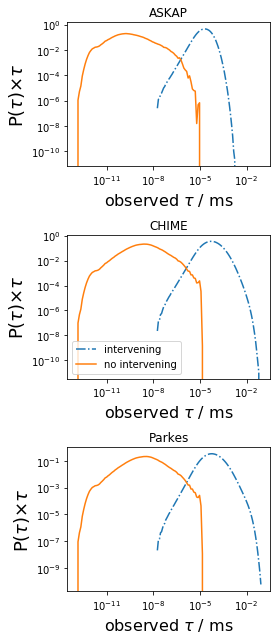

In [45]:
#fig, axs = plt.subplots( 1, len(telescopes), figsize=(4*len(telescopes), 3) )
fig, axs = plt.subplots( len(telescopes), 1, figsize=(4, len(telescopes)* 3) )

population = 'SMD'

for telescope, ax in zip( telescopes, axs):
    P_i, x_i = GetLikelihood_Telescope( measure='tau', telescope=telescope, population='SMD', **scenario_inter )
    PlotLikelihood( P=P_i, x=x_i, ax=ax, label='intervening', linestyle="-.", measure='tau' )
    P, x = GetLikelihood_Telescope( measure='tau', telescope=telescope, population='SMD', **scenario_nointer )
    PlotLikelihood( P=P, x=x, ax=ax, label='no intervening', linestyle="-", measure='tau' )
    ax.set_title(labels[telescope])
axs[1].legend()
fig.tight_layout()

calculate bayes factor and plot as function of $\tau$

True
73 3.0199517204020193e-06
ASKAP_incoh, 96.93 % of interveners identified
ASKAP_incoh, 0.00 % of others give false positives
True
87 5.754399373371567e-06
CHIME, 97.35 % of interveners identified
CHIME, 0.01 % of others give false positives
True
87 5.754399373371567e-06
Parkes, 97.55 % of interveners identified
Parkes, 0.01 % of others give false positives


/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


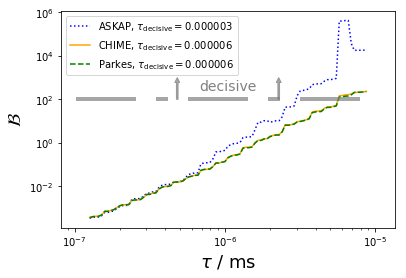

In [73]:
#fig, axs = plt.subplots( 1, len(telescopes), figsize=(4*len(telescopes), 3) )
fig, ax = plt.subplots()

population = 'SMD'

#for telescope, ax in zip( telescopes, axs):
for telescope, color, linestyle in zip(telescopes, colors_telescope, linestyles_population):
    P_i, x_i = GetLikelihood_Telescope( measure='tau', telescope=telescope, population='SMD', **scenario_inter )
    P, x = GetLikelihood_Telescope( measure='tau', telescope=telescope, population='SMD', **scenario_nointer )
    
    ## force both P to same range
    x_max = 1e-5 # np.max( [x[-1],x_i[-1]] )
    x_min = 1e-7 # 0.01
    x_0 = 10.**np.linspace( np.log10(x_min), np.log10(x_max), len(x) )
    P_0 = np.zeros(len(P))
#    print('x0',x_0[np.array([0,1,-1])], len(x))
#    print(x[np.array([0,1,-1])], len(x))
#    print(x_i[np.array([0,1,-1])], len(x_i))
    P, x = LikelihoodMeasureable( P=P, x=x, min=x_min, max=x_max)
    P_i, x_i = LikelihoodMeasureable( P=P_i, x=x_i, min=x_min, max=x_max)
#    print(x[np.array([0,1,-1])], len(x))
#    print(x_i[np.array([0,1,-1])], len(x_i))
    P, x = LikelihoodShrink(P=P, x=x)
    P_i, x_i = LikelihoodShrink(P=P_i, x=x_i)
#    print(x[np.array([0,1,-1])], len(x))
#    print(x_i[np.array([0,1,-1])], len(x_i))
    P, x = LikelihoodsAdd( Ps=[P,P_0], xs=[x,x_0] )
    P_i, x_i = LikelihoodsAdd( Ps=[P_i,P_0], xs=[x_i,x_0] )
    ## check if successfull
    print( np.all(x == x_i) )
#    print( (x==x_i)[np.array([0,1,-1])])
#    print(x[np.array([0,1,-1])], len(x))
#    print(x_i[np.array([0,1,-1])], len(x_i))
#    PlotLikelihood( P=P_i, x=x_i, ax=ax, label='intervening', linestyle="-." )
#    PlotLikelihood( P=P, x=x, ax=ax, label='intervening', linestyle="-" )
#    """
    
    B = P_i/P
    B[np.isnan(B)+np.isinf(B)] = np.nan
#    tau_decisive, B_tau = first( np.array([x[1:],B]).transpose(), lambda x: x[1] > 1e2 )
#    i_tau, (tau_decisive, B_tau) = first( enumerate(zip(x[1:],B)), lambda x: x[1] > 1e2 )
    i_tau = first( range(len(B)), lambda i: B[i] > 1e2 )
    tau_decisive = x[1:][i_tau]
#    print(B)
    print(i_tau, tau_decisive)
    ax.loglog( x[1:], B, label=r"%s, $\tau_{\rm decisive} = %.6f$" % (labels[telescope], tau_decisive), color=color, linestyle=linestyle )
    ax.set_xlabel( r"$\tau$ / ms", fontdict={'size':18 } )
    ax.set_ylabel( r"$\mathcal{B}$", fontdict={'size':18 }  )

    P_i, x_i = GetLikelihood_Telescope( measure='tau', telescope=telescope, population='SMD', **scenario_inter )
    P, x = GetLikelihood_Telescope( measure='tau', telescope=telescope, population='SMD', **scenario_nointer )

    i_tau = first( range(len(P_i)), lambda i: x_i[i] > tau_decisive )
    print( "%s, %.2f %% of interveners identified" % ( telescope, 100*np.sum( P_i[i_tau:]*np.diff(x_i)[i_tau:] ) ) )
    i_tau = first( range(len(P)), lambda i: x[i] > tau_decisive )
    print( "%s, %.2f %% of others give false positives" % ( telescope, 100*np.sum( P[i_tau:]*np.diff(x)[i_tau:] ) ) )
ax.legend()
PlotLimit(ax=ax, x=ax.get_xlim(), y=[1e2,1e2], lower_limit=True, label='decisive', shift_text_vertical=3e2)
#    """
    

In [59]:
a = np.arange(10)
b = np.arange(10)*2
x, (y,z) = first( enumerate(zip(a,b)), lambda x: x[1][1] > 3 )
print(x,y,z)

2 2 4


In [67]:
ix = first( range(len(a)), lambda i: b[i] >= 4)
print(ix, a[ix])

2 2
